In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from prophet import Prophet

In [17]:
start = datetime(2022, 10, 26)
end = datetime(2022,11,10)
forecast = datetime(2022,11,15)


query = "http://eaw-alplakes2:8000/bafu/hydrodata/measured/2027/PegelPneumatik/20221026/20221110"
response = requests.get(query)
if response.status_code == 200:
    data = response.json()
else:
    print(response.json())
    raise ValueError("Unable to download data, HTTP error code {}".format(response.status_code))

In [18]:
min_ = 372.2
max_ = 372.27

# Clean
df = pd.DataFrame(data)
df.columns = ["ds", "y"]
df["ds"] = pd.to_datetime(df["ds"], errors="coerce", utc=True)
df["y"] = pd.to_numeric(df["y"], errors="coerce")
df = df.dropna()
df['y'].where(df['y'] < max_, max_, inplace=True)
df['y'].where(df['y'] > min_, min_, inplace=True)

# Smooth
df["y"] = df["y"].rolling(window=144, win_type='gaussian', min_periods=10, center=True).mean(std=32)
df = df.dropna()

# Resample
dt=timedelta(minutes=10)
time = np.arange(start, end, dt)
f = interp1d(df["ds"].astype(int) / 10**9, df["y"], kind='linear', fill_value='extrapolate')
df = pd.DataFrame({"ds":time, "y": f(time.astype('int') / 10**6) })



In [19]:
df

,ds,y
0,2022-10-26 00:00:00,372.270000
1,2022-10-26 00:10:00,372.270000
2,2022-10-26 00:20:00,372.270000
3,2022-10-26 00:30:00,372.270000
4,2022-10-26 00:40:00,372.270000
...,...,...
2155,2022-11-09 23:10:00,372.232762
2156,2022-11-09 23:20:00,372.232755
2157,2022-11-09 23:30:00,372.232749
2158,2022-11-09 23:40:00,372.232735


In [20]:
m = Prophet()
m.fit(df)

16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
time = np.arange(start, forecast, dt)
future = pd.DataFrame({"ds": time})

In [22]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2875,2022-11-14 23:10:00,372.270618,372.146698,372.400733
2876,2022-11-14 23:20:00,372.270468,372.145934,372.400535
2877,2022-11-14 23:30:00,372.270321,372.146448,372.401983
2878,2022-11-14 23:40:00,372.270176,372.144925,372.402771
2879,2022-11-14 23:50:00,372.270034,372.145290,372.400958


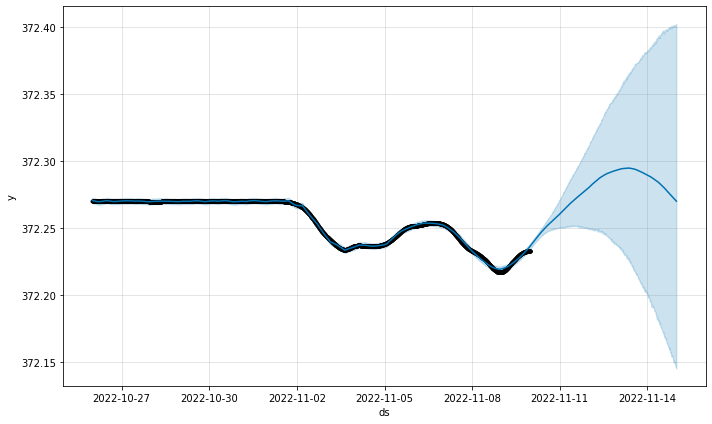

In [23]:
fig1 = m.plot(forecast)

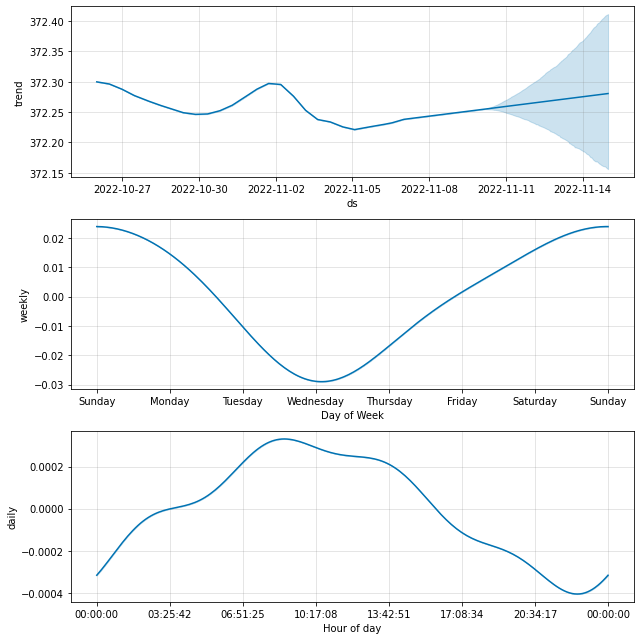

In [24]:
fig2 = m.plot_components(forecast)